# 10. Plot the conversion tracts
Make plots that have a sliding window pairwise distance between the homeologues of each sample, and the mismatch positions in each sample
## 10.1 Prerequesites

In [ ]:
import glob, misc, os
from Bio import AlignIO
from collections import Counter
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment

def build_empty_dist_dict(aln):
    dist_dict = {}
    counter = Counter([r.id.split('_')[0] for r in aln])
    
    for sp in counter:
        if counter[sp] == 2 and not sp == 'MentL30':
            dist_dict[sp] = ['x']*len(aln[0])
    return dist_dict

def fill_in_missing_data(aln, dist_dict):
    
    for sp in dist_dict:
        records = [r for r in aln if r.id.split('_')[0] == sp]
        i = 0
        while '-' in records[0].seq[i] + records[1].seq[i]:
            dist_dict[sp][i] = None
            i+=1
        i = len(aln[0])-1
        while '-' in records[0].seq[i] + records[1].seq[i]:
            dist_dict[sp][i] = None
            i-=1
            
    return dist_dict

def is_pos_ident_in_sp(sub_aln, sp, pos):
    records = [r for r in sub_aln if r.id.split('_')[0] == sp]
    col = records[0].seq[pos] + records[1].seq[pos]
    if col[0] == col[1]:
        return True
    else:
        return False
    
def get_sub_aln(aln, start, length):
    end = start+length
    if start+length > len(aln[0]):
        end = aln.get_alignment_length()
    return aln[:,start:end]

def get_subset_dists(sub_aln, dist_dict):
    subset_dists = {sp: [] for sp in dist_dict}
    sub_aln_len = sub_aln.get_alignment_length()
    for pos in range(sub_aln_len):
        for sp in subset_dists:
            subset_dists[sp].append(is_pos_ident_in_sp(sub_aln, sp, pos))
    
    subset_dist = {}
    
    for sp in subset_dists:
        if subset_dists[sp].count(True)+subset_dists[sp].count(False) == 0:
            subset_dist[sp] = None
        else:
            subset_dist[sp] = subset_dists[sp].count(False)/float(subset_dists[sp].count(True)+
                                                                  subset_dists[sp].count(False)) 
    return subset_dist
            
def get_pairwise_sliding_window_dists(aln):
    
    dist_dict = build_empty_dist_dict(aln)
    dist_dict = fill_in_missing_data(aln, dist_dict)
    mismatch_dict = {sp: [] for sp in dist_dict}
    
    aln_len = len(aln[0])
    
    window_size = 20
    
    for pos in range(aln_len):
        sub_aln = get_sub_aln(aln, pos, window_size)
        window_dists = get_subset_dists(sub_aln, dist_dict)
        for sp in dist_dict:
            if dist_dict[sp][pos]:
                dist_dict[sp][pos] = window_dists[sp]
                if not is_pos_ident_in_sp(aln, sp, pos):
                    mismatch_dict[sp].append(pos)
            
    return dist_dict, mismatch_dict

def plot(dist_dict, mismatch_dict, OG, fig_dir):
    fig, ax = plt.subplots(figsize=(15,5))
    
    for sp in dist_dict:
        color = 'red'
        m = '.'
        w=1
        j=0.94
        if 'Mjav' in sp:
            color = 'blue'
            j=0.94
        elif 'Mare' in sp:
            color = 'green'
            j=0.97
        elif 'Mflo' in sp:
            color = 'black'
            w=4
            j=0.99
        
        ax.plot(range(len(dist_dict[sp])), dist_dict[sp], color=color, linewidth=w)
        ax.plot(mismatch_dict[sp], [j]*len(mismatch_dict[sp]), m,color=color)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)

    plt.xlabel('Alignment position', fontsize=12)
    ax.set_ylabel('Pairwise distance', fontsize=12)
    plt.title(OG)
    plt.savefig(fig_dir.rstrip('/')+'/'+OG+'.png', dpi=300)

    plt.close('all')

## 10.2 Plot

In [264]:
# This will not work now because I rename the alignment files further down
alns_glob = './orthofinder/all_inputs/Results_Jul02/I2_2X2_gt0.85_st0.005_alns_flo2/RAxML*.fasta'
iter_aln_files = glob.glob(alns_glob)

fig_dir = './orthofinder/all_inputs/Results_Jul02/I2_2X2_gt0.85_st0.005_alns_flo2'
for f in iter_aln_files:
    OG = f.split('_')[-1].split('.')[0]
    aln = AlignIO.read(f,'fasta')
    dist_dict, mismatch_dict = get_pairwise_sliding_window_dists(aln)
    plot(dist_dict, mismatch_dict, OG, fig_dir)

## 10.3 treeCl analysis for orthoilogy clusters with two copies of MfloSJF1

Loading files: 36 of 36 |#################| Elapsed Time: 0:00:00 Time: 0:00:00
Raxml Tree estimation: 36 of 36 |#########| Elapsed Time: 0:00:25 Time: 0:00:25


mds clusters [35, 1]


WeightedRFDistance: 630 of 630 |##########| Elapsed Time: 0:00:14 Time: 0:00:14


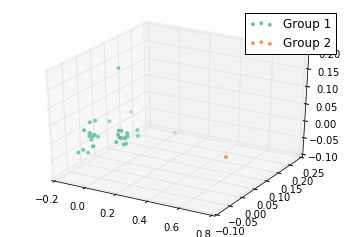

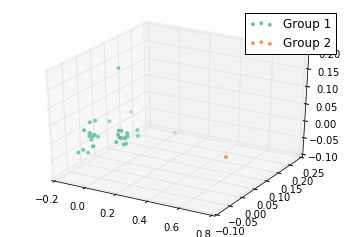

In [3]:
import treeCl, glob, os
alndir = 'orthofinder/all_inputs/Results_Jul02/I2_2X2_gt0.85_st0.005_alns_flo2'

for f in glob.glob(alndir+'/*.fasta'):
    newf = f.replace('RAxML_bestTree.','').replace('284421467500872.59_','')
    os.rename(f, newf)


c = treeCl.Collection(input_dir=alndir, file_format='fasta')

c.calc_trees(executable='raxmlHPC-PTHREADS',  # specify raxml binary to use
             threads=14,  # use multithreaded raxml
             model='GTRGAMMA',  # this model of evolution
             fast_tree=False)

dm = c.get_inter_tree_distances('wrf')

aclust = treeCl.Automatic(dm)
mdsclust = treeCl.MultidimensionalScaling(dm)

mds_partitions = mdsclust.cluster(2)

mds_clustlengths = [len(a) for a in mds_partitions]
mds_kpca = mdsclust.dm.embedding(3, 'kpca')

print 'mds clusters', mds_clustlengths

%matplotlib inline
treeCl.plotter.plot_embedding(mds_kpca,partition=mds_partitions)

In [ ]:
raxml = treeCl.tasks.RaxmlTaskInterface()
sc = treeCl.Scorer(c, cache_dir = alndir.replace('alns','cache_alignments'),
                   task_interface=raxml) 

sc.write_partition(mds_partitions)

results = sc.analyse_cache_dir(executable='raxmlHPC-PTHREADS', threads=14)

# Get a list of the loci in each group
loci = sc.get_partition_members(mds_partitions)

with open(alndir+'/loci.txt','wt') as hndl:
    hndl.write(str(loci))

# Get trees for each group

trees = sc.get_partition_trees(mds_partitions)

from reprophylodev import *

for i in range(len(mds_clustlengths)):
    
    title = "Inflation 2, no CDS align, 3X2, gt 0.85, st 0.005, cluster %i, %i loci" % (i, mds_clustlengths[i])

    ns = NodeStyle()
    ns['size'] = 0
    ns['vt_line_width'] = 2
    ns['hz_line_width'] = 2
    ts = TreeStyle()
    ts.title.add_face(TextFace(title, fsize=20), column=0)
    ts.show_leaf_name=False

    colors = {
        'Minc':'Red',
        'Mjav':'Blue',
        'Mflo':'Black',
        'Mare':'Green',
        'Ment':'gray'
    }

    t = Tree(trees[i])
    t.dist = 0
    try:
        t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
    except:
        t.set_outgroup('MentL30_1')

    for n in t.traverse():
        if n.is_leaf():
            text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

            fgcolor = 'black'
            try:
                fgcolor=colors[text[:4]]
            except:
                fgcolor = 'black'

            n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                       0,position='branch-right')

        n.set_style(ns)
    t.render(alndir+'/cluster_%i.png'%i,tree_style=ts, dpi=300)

## 10.4 treeCl analysis of the same set, including only positions that are heterozygouse in MfloSJF1

In [ ]:
for f in glob.glob(alndir+'/*.fasta'):
    newdir = alndir+'_nonconverted'
    aln = AlignIO.read(f,'fasta')
    newaln = aln[:,:1]
    mflo1 = str([r for r in aln if r.id == 'MfloSJF1_1'][0].seq)
    mflo2 = str([r for r in aln if r.id == 'MfloSJF1_2'][0].seq)
    for i in range(1,aln.get_alignment_length()):
        if mflo1[i] != mflo2[i]:
            newaln += aln[:,i:i+1]
    AlignIO.write(newaln,newdir + '/' + f.split('/')[-1],'fasta')

import treeCl, glob, os
alndir = '/home/amir/Dropbox/Nematodes/Meloidogyne_hybrids/Homeologue_phylogenomics'
alndir += '/orthofinder/all_inputs/Results_Jul02/I2_2X2_gt0.85_st0.005_alns_flo2_nonconverted'

for f in glob.glob(alndir+'/*.fasta'):
    newf = f.replace('RAxML_bestTree.','').replace('284421467500872.59_','')
    os.rename(f, newf)


c = treeCl.Collection(input_dir=alndir, file_format='fasta')

c.calc_trees(executable='raxmlHPC-PTHREADS',  # specify raxml binary to use
             threads=14,  # use multithreaded raxml
             model='GTRGAMMA',  # this model of evolution
             fast_tree=False)

dm = c.get_inter_tree_distances('wrf')

aclust = treeCl.Automatic(dm)
mdsclust = treeCl.MultidimensionalScaling(dm)

mds_partitions = mdsclust.cluster(2)

mds_clustlengths = [len(a) for a in mds_partitions]

mds_kpca = mdsclust.dm.embedding(3, 'kpca')

print 'mds clusters', mds_clustlengths

%matplotlib inline
treeCl.plotter.plot_embedding(mds_kpca,partition=mds_partitions)

raxml = treeCl.tasks.RaxmlTaskInterface()
sc = treeCl.Scorer(c, cache_dir = alndir.replace('alns','cache_alignments'),
                   task_interface=raxml) 

sc.write_partition(mds_partitions)

results = sc.analyse_cache_dir(executable='raxmlHPC-PTHREADS', threads=14)

# Get a list of the loci in each group
loci = sc.get_partition_members(mds_partitions)

with open(alndir+'/loci.txt','wt') as hndl:
    hndl.write(str(loci))

# Get trees for each group

trees = sc.get_partition_trees(mds_partitions)

from reprophylodev import *

for i in range(len(mds_clustlengths)):
    
    title = "Inflation 2, non converted, no CDS align, 2X2, gt 0.85, st 0.005, cluster %i, %i loci" % (i, mds_clustlengths[i])

    ns = NodeStyle()
    ns['size'] = 0
    ns['vt_line_width'] = 2
    ns['hz_line_width'] = 2
    ts = TreeStyle()
    ts.title.add_face(TextFace(title, fsize=20), column=0)
    ts.show_leaf_name=False

    colors = {
        'Minc':'Red',
        'Mjav':'Blue',
        'Mflo':'Black',
        'Mare':'Green',
        'Ment':'gray'
    }

    t = Tree(trees[i])
    t.dist = 0
    try:
        t.set_outgroup(t.get_common_ancestor('MentL30_1','MentL30_2'))
    except:
        t.set_outgroup('MentL30_1')

    for n in t.traverse():
        if n.is_leaf():
            text = n.name.replace('MincL17','MjavLD17').replace('MincL15','MjavLD17')

            fgcolor = 'black'
            try:
                fgcolor=colors[text[:4]]
            except:
                fgcolor = 'black'

            n.add_face(TextFace(text,ftype='arial',fsize=12,fgcolor=fgcolor),
                       0,position='branch-right')

        n.set_style(ns)
    t.render(alndir+'/cluster_%i.png'%i,tree_style=ts, dpi=300)

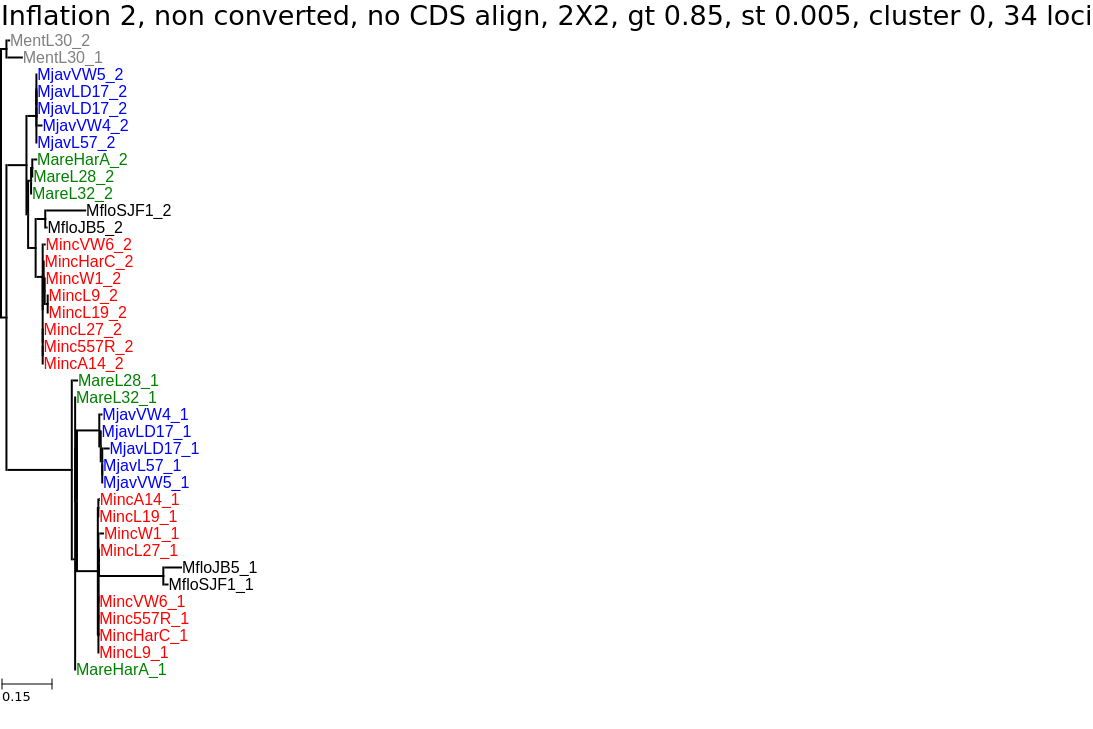

In [1]:
from IPython.display import Image
Image('orthofinder/all_inputs/Results_Jul02/I2_2X2_gt0.85_st0.005_alns_flo2_nonconverted/cluster_0.png')